# Load các thư viện cần sử dụng

In [93]:
import sklearn
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [94]:
data = pd.read_csv('comment_tiki.csv')
data.head()

,Comment,Label
0,"Sản phẩm ok nhé, Ghi nồi 3L nhưng không biết l...",Positive
1,Mình mua về dùng được mấy tháng rồi mới nhận x...,Positive
2,nhận hàng cực nhanh các mom ạ. mệt mỏi bữa giờ...,Positive
3,Tuyệt vời ông mặt trời lun. Ngày trước cứ phân...,Positive
4,Hàng đóng gói rất cẩn thận. Nồi dùng rất tiện....,positive


In [95]:
data.groupby(['Label']).size()

Label
Negative      8
Neutral       4
Positive     42
negative    101
neutral      61
positive    252
dtype: int64

# **Prepare data**

# Sửa lại để các label cùng loại giống nhau

In [124]:
data['Label'].replace({"Negative": "negative", "Positive": "positive", "Neutral": "neutral"}, inplace=True)
print('Tổng số mẫu tích cực:', (data.Label == 'positive').sum())
print('Tổng số mẫu tiêu cực:', (data.Label == 'negative').sum())
print('Tổng số mẫu trung tính:', (data.Label == 'neutral').sum())
print('Tổng số mẫu:', len(data))

Tổng số mẫu tích cực: 294
Tổng số mẫu tiêu cực: 109
Tổng số mẫu trung tính: 65
Tổng số mẫu: 469


# Chuyển đổi label sang dạng số: 0 - neutral, 1 - positive, -1 - negative

In [97]:
data['output'] = np.where(
    data['Label'] == 'neutral', 0, np.where(
    data['Label'] == 'positive', 1, -1)) 

# Chuẩn hóa dữ liệu cột comment

In [98]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

data = standardize_text(data, "Comment")

C:\Users\Admin\AppData\Local\Temp/ipykernel_2328/1314007245.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
C:\Users\Admin\AppData\Local\Temp/ipykernel_2328/1314007245.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")


# Tạo dữ liệu để train và test

In [99]:
# Trộn các mẫu lên
data = data.sample(n = len(data), random_state = 42)
data = data.reset_index(drop = True)

valid_test = data.sample(frac = 0.3, random_state = 42)
test = valid_test.sample(frac = 0.5, random_state = 42)
valid = valid_test.drop(test.index)

# Phần còn lại là train data
train = data.drop(valid_test.index)

print('Tỉ lệ những feedback tích cực:')
print('- trong tập test (n = %d):'%len(test), test.output.sum()/ len(test))
print('- trong tập valid (n = %d):'%len(valid), valid.output.sum()/ len(valid))
print('- trong tập train (n = %d):'%len(train), train.output.sum()/ len(train))
print('Tổng cộng (n = %d)'%len(data))

Tỉ lệ những feedback tích cực:
- trong tập test (n = 70): 0.4714285714285714
- trong tập valid (n = 71): 0.4507042253521127
- trong tập train (n = 328): 0.3628048780487805
Tổng cộng (n = 469)


Phân bố dữ liệu tương đối tốt

# Preprocess text data

**Build a tokenizer**

In [100]:
data.head()

,Comment,Label,output
0,khi nhận hàng máy được bao bọc rất kỹ. máy có ...,positive,1
1,"khai nồi bằng món gà nướng. giao hàng nhanh, b...",positive,1
2,năm ngoái mình đã mua nồi chiên lnl loại cơ ( ...,positive,1
3,lớp chống dính không tốt,negative,-1
4,không có hàng khuyến mại đi kèm,negative,-1


In [106]:
from nltk.tokenize import RegexpTokenizer

my_tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['Comment'].apply(my_tokenizer.tokenize)
data.head()

,Comment,Label,output,tokens
0,khi nhận hàng máy được bao bọc rất kỹ. máy có ...,positive,1,"[khi, nhận, hàng, máy, được, bao, bọc, rất, kỹ..."
1,"khai nồi bằng món gà nướng. giao hàng nhanh, b...",positive,1,"[khai, nồi, bằng, món, gà, nướng, giao, hàng, ..."
2,năm ngoái mình đã mua nồi chiên lnl loại cơ ( ...,positive,1,"[năm, ngoái, mình, đã, mua, nồi, chiên, lnl, l..."
3,lớp chống dính không tốt,negative,-1,"[lớp, chống, dính, không, tốt]"
4,không có hàng khuyến mại đi kèm,negative,-1,"[không, có, hàng, khuyến, mại, đi, kèm]"


# Khám phá dữ liệu nhiều hơn tí

In [107]:
all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
vocab = sorted(list(set(all_words)))
print("Tổng cộng %s từ, với kích thước vocabulary là %s" % (len(all_words), len(vocab)))
print("Câu dài nhất có kích thước %s từ" % max(sentence_lengths))

Tổng cộng 15877 từ, với kích thước vocabulary là 1473
Câu dài nhất có kích thước 143 từ


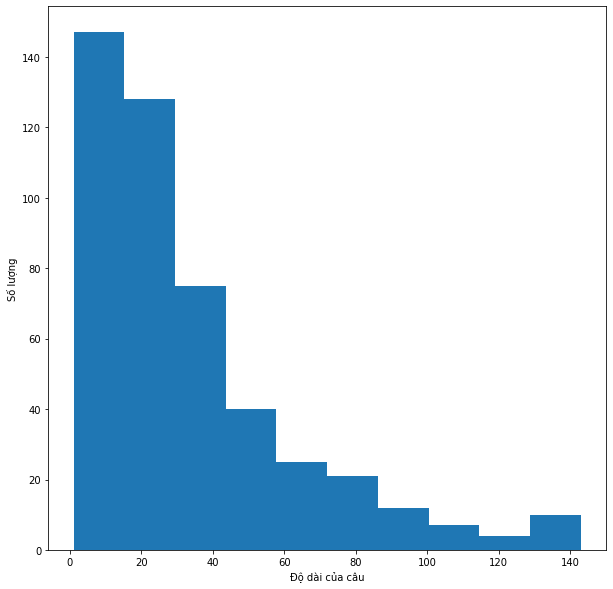

In [108]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Độ dài của câu')
plt.ylabel('Số lượng')
plt.hist(sentence_lengths)
plt.show()

# **Sử dụng machine learning**

# Bag of Words (One hot encoding)

In [ ]:
#print("Tạo list stop word tiếng Việt")
#my_file = open("sample.txt", "r")
#content_list = my_file.readlines()
#print(content_list)

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(train.Comment)
X_test_counts = count_vectorizer.transform(test.Comment)

# Xây dựng một mô hình phân loại đơn giản

In [120]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
                         
clf.fit(X_train_counts, train.output)
y_predicted_counts = clf.predict(X_test_counts)

# Đánh giá

In [121]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(test.output, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.743, precision = 0.741, recall = 0.743, f1 = 0.739


# Cải tiến model:
Xem list những từ quan trọng nhất

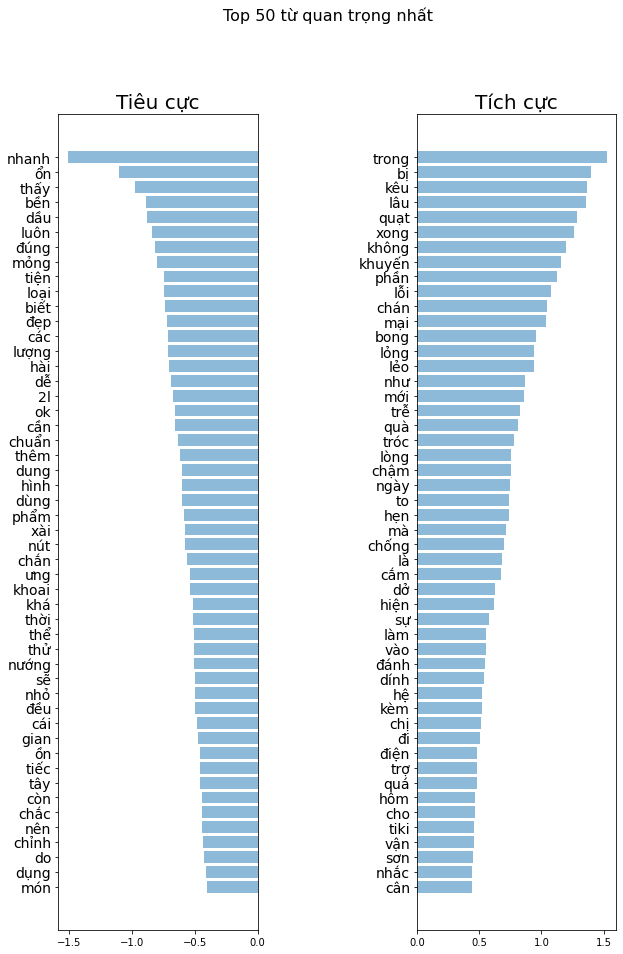

In [123]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Tiêu cực', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    #plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Tích cực', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    #plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(count_vectorizer, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Top 50 từ quan trọng nhất")